#**Title** : Predictive Analytics in Finance: Machine Learning for Stock Prices
## *Leverages advanced algorithms to analyse historical data, identify patterns, and forecast market trends. It empowers investors with data-driven insights to optimize trading strategies and improve decision-making*

In [1]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installing pySpark libraries

In [2]:
!pip install pyspark py4j

### To use PySpark for data processing, you need to first initialize a SparkSession

In [3]:
from pyspark.sql import SparkSession

# local[*] → It defines the number of available CPU cores to be used.
# getOrCreate → It creates a new session if the defined session is already not created.lm
spark = SparkSession.builder.master("local[1]").appName("stock_prediction").getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

spark

In [4]:
TICKER = "BAC"  # Taking 'Bank of America Corp (BAC)' for stock price prediction.

import datetime

start_date = datetime.datetime(1950,1,1)
end_date = datetime.datetime(2024,10,31)

### The yfinance is a popular Python library used for downloading market data from Yahoo Finance. It simplifies the process of fetching historical market data, allowing developers to focus on analysis and strategy development.

In [5]:
import yfinance as yf

bac_stock_info = yf.Ticker(TICKER)

print("General information about 'Bank of America")
print(bac_stock_info.info)

General information about 'Bank of America
{'address1': 'Bank of America Corporate Center', 'address2': '100 North Tryon Street', 'city': 'Charlotte', 'state': 'NC', 'zip': '28255', 'country': 'United States', 'phone': '704 386 5681', 'website': 'https://www.bankofamerica.com', 'industry': 'Banks - Diversified', 'industryKey': 'banks-diversified', 'industryDisp': 'Banks - Diversified', 'sector': 'Financial Services', 'sectorKey': 'financial-services', 'sectorDisp': 'Financial Services', 'longBusinessSummary': 'Bank of America Corporation, through its subsidiaries, provides banking and financial products and services for individual consumers, small and middle-market businesses, institutional investors, large corporations, and governments worldwide. It operates in four segments: Consumer Banking, Global Wealth & Investment Management (GWIM), Global Banking, and Global Markets. The Consumer Banking segment offers traditional and money market savings accounts, certificates of deposit and I

In [6]:
df_yahoo = yf.download(TICKER, start=start_date, end=end_date)

df_yahoo.index.name = 'Date'
df_yahoo.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

df_yahoo.to_csv("/content/stock_prices_feed.csv")

df_yahoo.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1973-02-21,1.542558,4.625000,4.625000,4.625000,4.625000,99200
1973-02-22,1.547771,4.640625,4.640625,4.640625,4.640625,47200
1973-02-23,1.542558,4.625000,4.625000,4.625000,4.625000,133600
1973-02-26,1.542558,4.625000,4.625000,4.625000,4.625000,24000
1973-02-27,1.542558,4.625000,4.625000,4.625000,4.625000,41600


In [7]:
df_pyspark = spark.read\
                .option("header", "true")\
                .option("inferSchema", "true")\
                .csv("/content/stock_prices_feed.csv")

### **Exploratory Data Analysis**

In [8]:
# Print Schema in a tree format.

df_pyspark.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: integer (nullable = true)



In [9]:
# Show Date column from dataframe

df= df_pyspark.select(['Date'])
df.head(5)

[Row(Date=datetime.date(1973, 2, 21)),
 Row(Date=datetime.date(1973, 2, 22)),
 Row(Date=datetime.date(1973, 2, 23)),
 Row(Date=datetime.date(1973, 2, 26)),
 Row(Date=datetime.date(1973, 2, 27))]

In [10]:
df_pyspark.head(5)

[Row(Date=datetime.date(1973, 2, 21), Adj Close=1.542557954788208, Close=4.625, High=4.625, Low=4.625, Open=4.625, Volume=99200),
 Row(Date=datetime.date(1973, 2, 22), Adj Close=1.5477708578109741, Close=4.640625, High=4.640625, Low=4.640625, Open=4.640625, Volume=47200),
 Row(Date=datetime.date(1973, 2, 23), Adj Close=1.542557954788208, Close=4.625, High=4.625, Low=4.625, Open=4.625, Volume=133600),
 Row(Date=datetime.date(1973, 2, 26), Adj Close=1.542557954788208, Close=4.625, High=4.625, Low=4.625, Open=4.625, Volume=24000),
 Row(Date=datetime.date(1973, 2, 27), Adj Close=1.542557954788208, Close=4.625, High=4.625, Low=4.625, Open=4.625, Volume=41600)]

In [11]:
df_pyspark.tail(5)

[Row(Date=datetime.date(2024, 10, 24), Adj Close=42.414066314697266, Close=42.650001525878906, High=42.65999984741211, Low=41.970001220703125, Open=42.31999969482422, Volume=28392000),
 Row(Date=datetime.date(2024, 10, 25), Adj Close=41.658267974853516, Close=41.88999938964844, High=42.97999954223633, Low=41.790000915527344, Open=42.91999816894531, Volume=27466900),
 Row(Date=datetime.date(2024, 10, 28), Adj Close=42.38422775268555, Close=42.619998931884766, High=42.75, Low=42.0099983215332, Open=42.06999969482422, Volume=24527600),
 Row(Date=datetime.date(2024, 10, 29), Adj Close=42.29472732543945, Close=42.529998779296875, High=42.810001373291016, Low=42.470001220703125, Open=42.59000015258789, Volume=22313500),
 Row(Date=datetime.date(2024, 10, 30), Adj Close=42.07594680786133, Close=42.310001373291016, High=42.900001525878906, Low=41.63999938964844, Open=41.709999084472656, Volume=38100500)]

In [12]:
df_pyspark.show()

+----------+------------------+--------+--------+--------+--------+------+
|      Date|         Adj Close|   Close|    High|     Low|    Open|Volume|
+----------+------------------+--------+--------+--------+--------+------+
|1973-02-21| 1.542557954788208|   4.625|   4.625|   4.625|   4.625| 99200|
|1973-02-22|1.5477708578109741|4.640625|4.640625|4.640625|4.640625| 47200|
|1973-02-23| 1.542557954788208|   4.625|   4.625|   4.625|   4.625|133600|
|1973-02-26| 1.542557954788208|   4.625|   4.625|   4.625|   4.625| 24000|
|1973-02-27| 1.542557954788208|   4.625|   4.625|   4.625|   4.625| 41600|
|1973-02-28| 1.542557954788208|   4.625|   4.625|   4.625|   4.625| 66400|
|1973-03-01|1.5529818534851074| 4.65625| 4.65625| 4.65625| 4.65625| 93600|
|1973-03-02|1.5581920146942139|4.671875|4.671875|4.671875|4.671875| 26400|
|1973-03-05|1.5790385007858276|4.734375|4.734375|4.734375|4.734375| 68000|
|1973-03-06|1.6259409189224243|   4.875|   4.875|   4.875|   4.875| 76800|
|1973-03-07|1.62594091892

In [13]:
df_pyspark.columns

['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

**Let’s explore the data by calculating some basic statistics such as the average closing price per year and per month for each stock dataset¶**

In [14]:
from pyspark.sql.functions import mean, stddev, corr

mean_price = df_pyspark.select(mean("Close")).first()[0]
stddev_price = df_pyspark.select(stddev("Close")).first()[0]
corr_price_volume = df_pyspark.select(corr("Close", "Volume")).first()[0]

print("Mean Price:", mean_price)
print("Standard Deviation Price:", stddev_price)
print("Correlation between Price and Volume:", corr_price_volume)

Mean Price: 18.24658385613876
Standard Deviation Price: 14.652486541522679
Correlation between Price and Volume: 0.007640753303962075


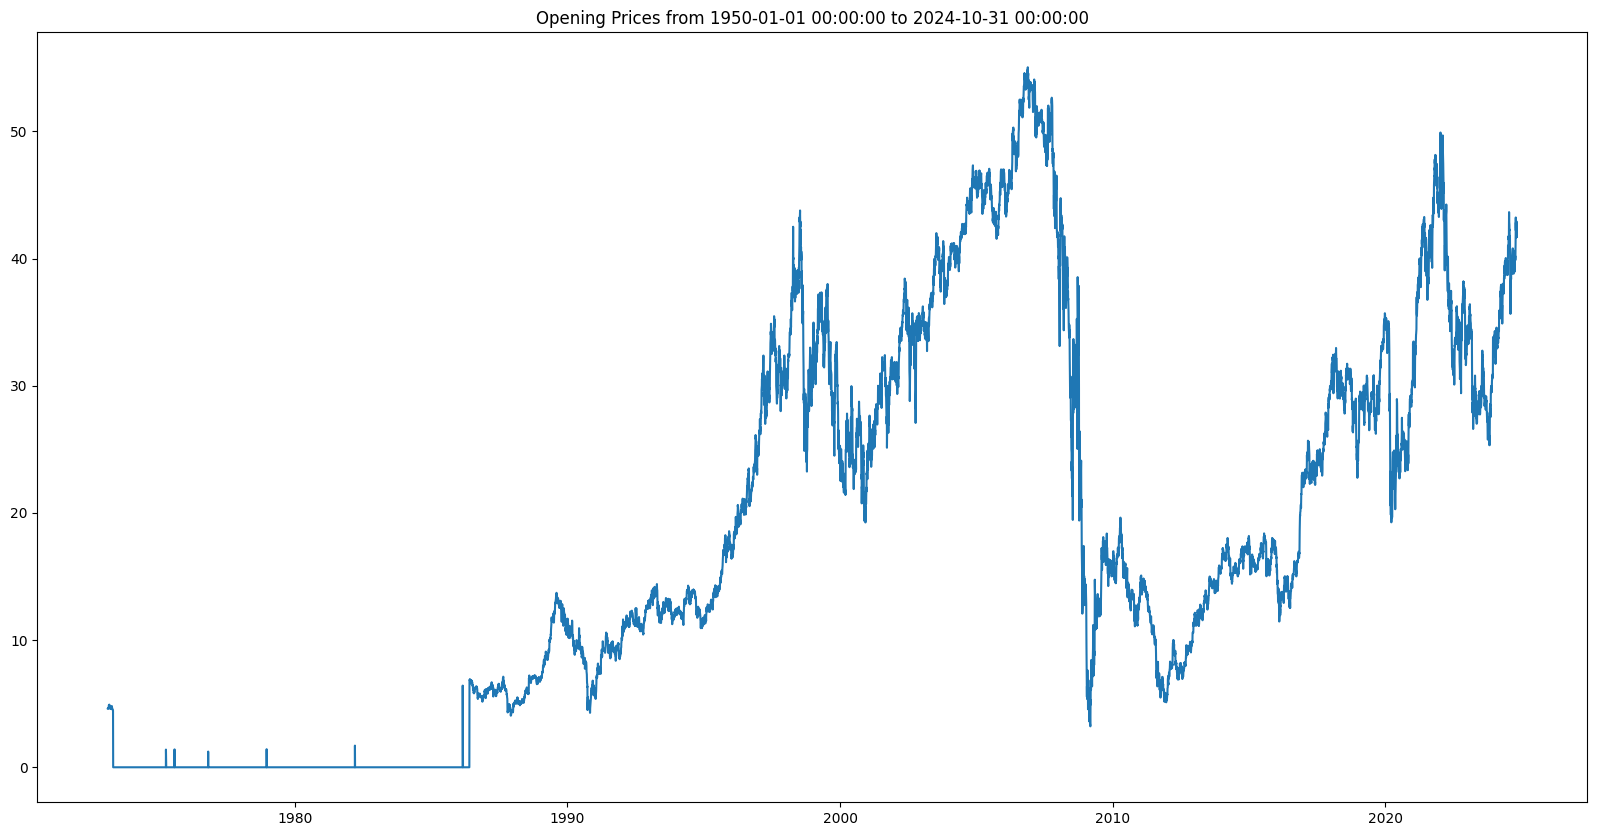

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
plt.title('Opening Prices from {} to {}'.format(start_date, end_date))
plt.plot(df_yahoo['Open'])
plt.show()

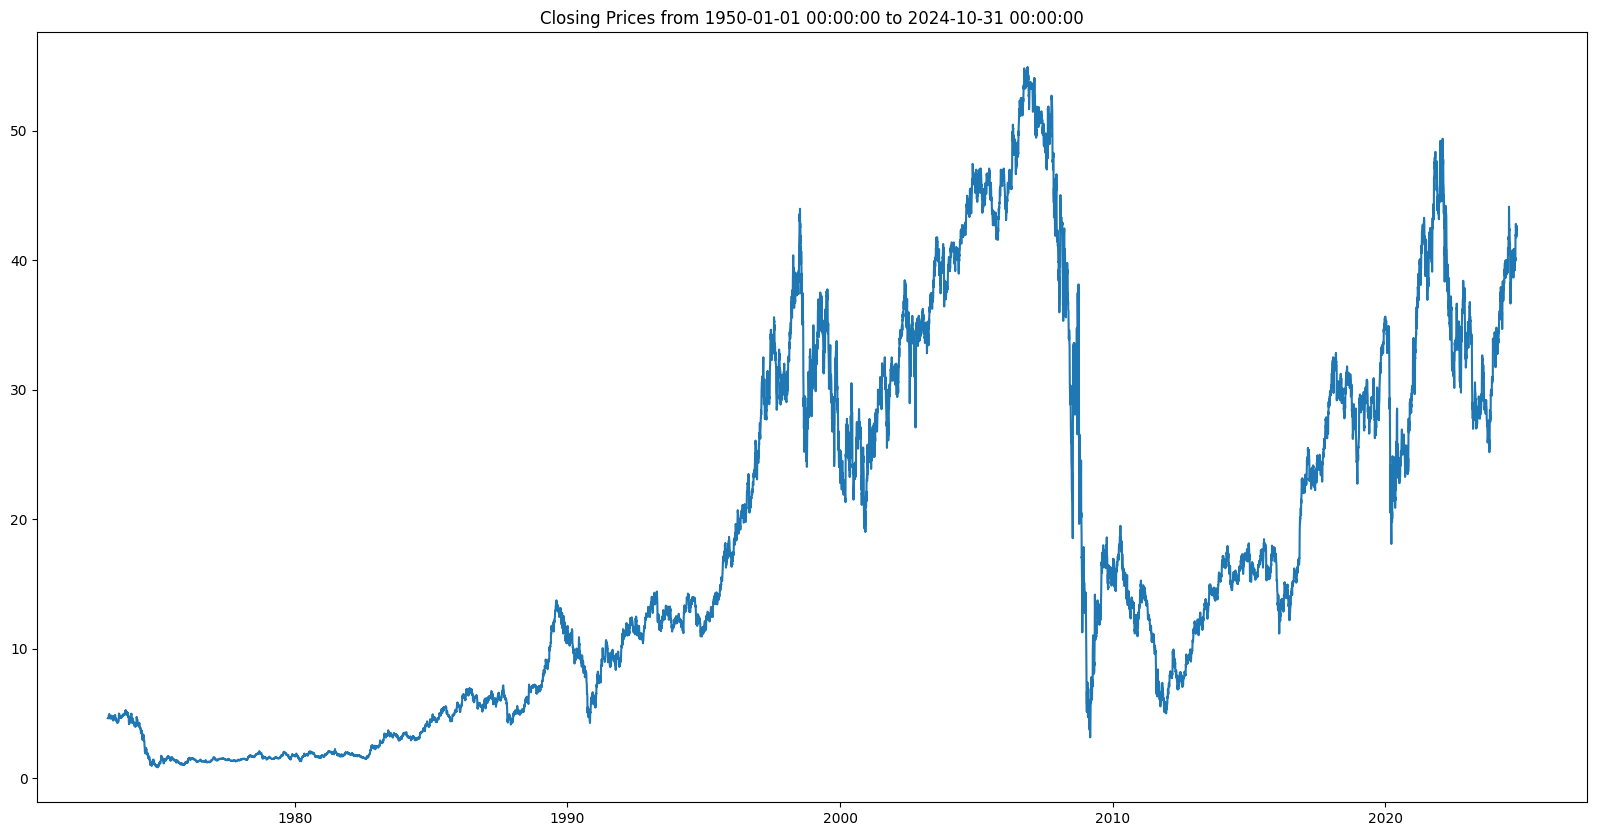

In [16]:
plt.figure(figsize = (20,10))
plt.title('Closing Prices from {} to {}'.format(start_date, end_date))
plt.plot(df_yahoo['Close'])
plt.show()

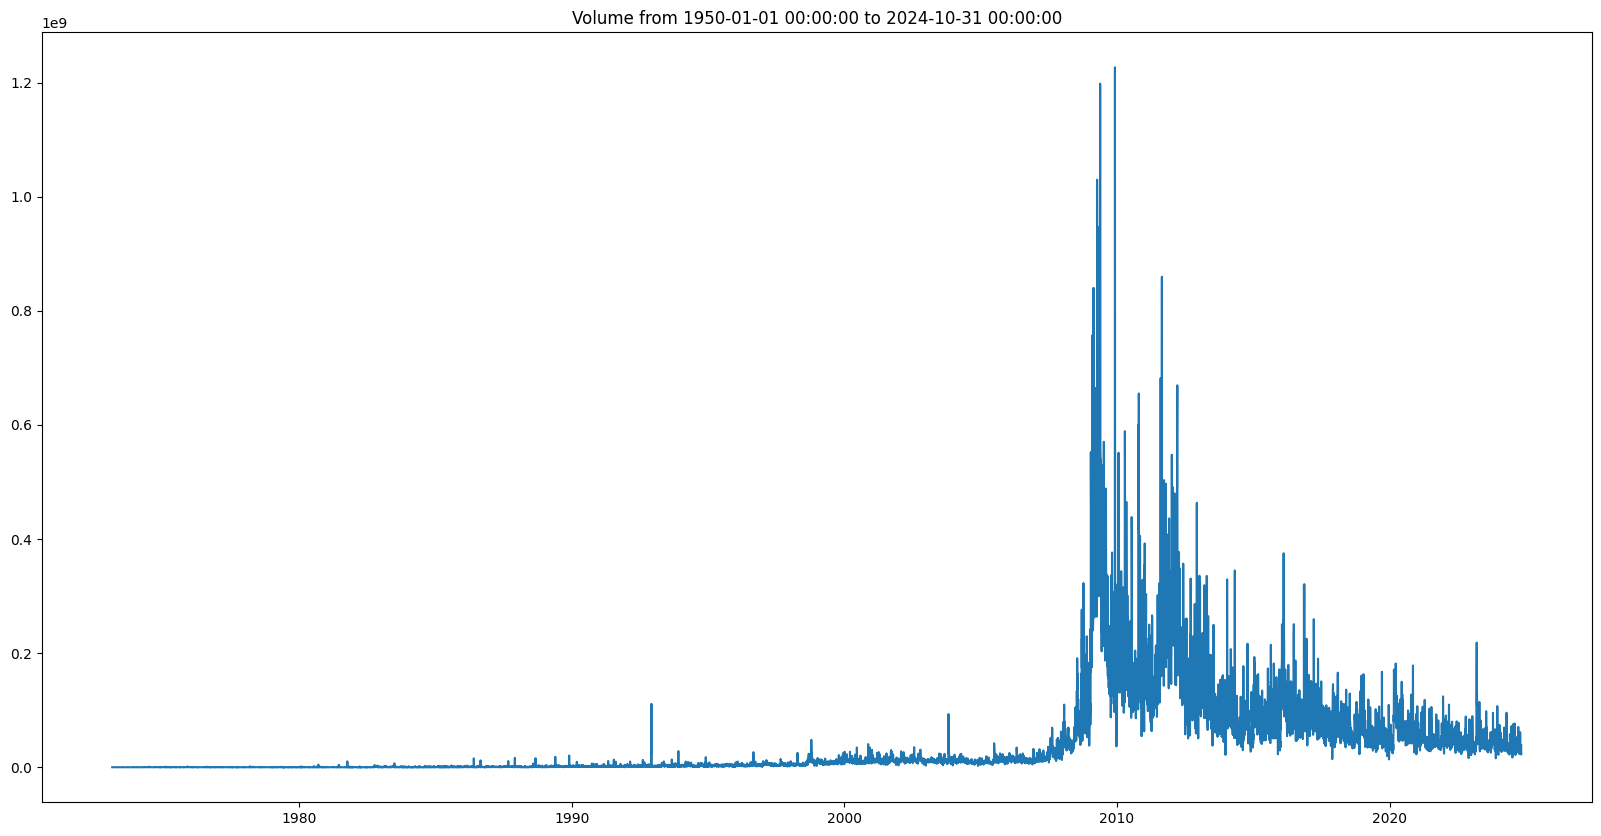

In [17]:
plt.figure(figsize = (20,10))
plt.title('Volume from {} to {}'.format(start_date, end_date))
plt.plot(df_yahoo['Volume'])
plt.show()

<Axes: title={'center': 'Bank of America Stock(BAC) Price'}, xlabel='Date'>

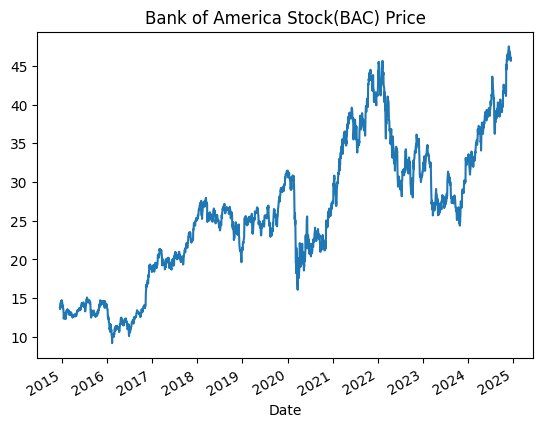

In [18]:
ticker = yf.Ticker('BAC')
bac_df = ticker.history(period="10y")
bac_df['Close'].plot(title="Bank of America Stock(BAC) Price")

+----------+------------------+--------+--------+--------+--------+------+-----------------+
|Date      |Adj Close         |Close   |High    |Low     |Open    |Volume|rolling_average  |
+----------+------------------+--------+--------+--------+--------+------+-----------------+
|1973-02-21|1.542557954788208 |4.625   |4.625   |4.625   |4.625   |99200 |18.24658385613876|
|1973-02-22|1.5477708578109741|4.640625|4.640625|4.640625|4.640625|47200 |18.24658385613876|
|1973-02-23|1.542557954788208 |4.625   |4.625   |4.625   |4.625   |133600|18.24658385613876|
|1973-02-26|1.542557954788208 |4.625   |4.625   |4.625   |4.625   |24000 |18.24658385613876|
|1973-02-27|1.542557954788208 |4.625   |4.625   |4.625   |4.625   |41600 |18.24658385613876|
|1973-02-28|1.542557954788208 |4.625   |4.625   |4.625   |4.625   |66400 |18.24658385613876|
|1973-03-01|1.5529818534851074|4.65625 |4.65625 |4.65625 |4.65625 |93600 |18.24658385613876|
|1973-03-02|1.5581920146942139|4.671875|4.671875|4.671875|4.671875|264

<Axes: >

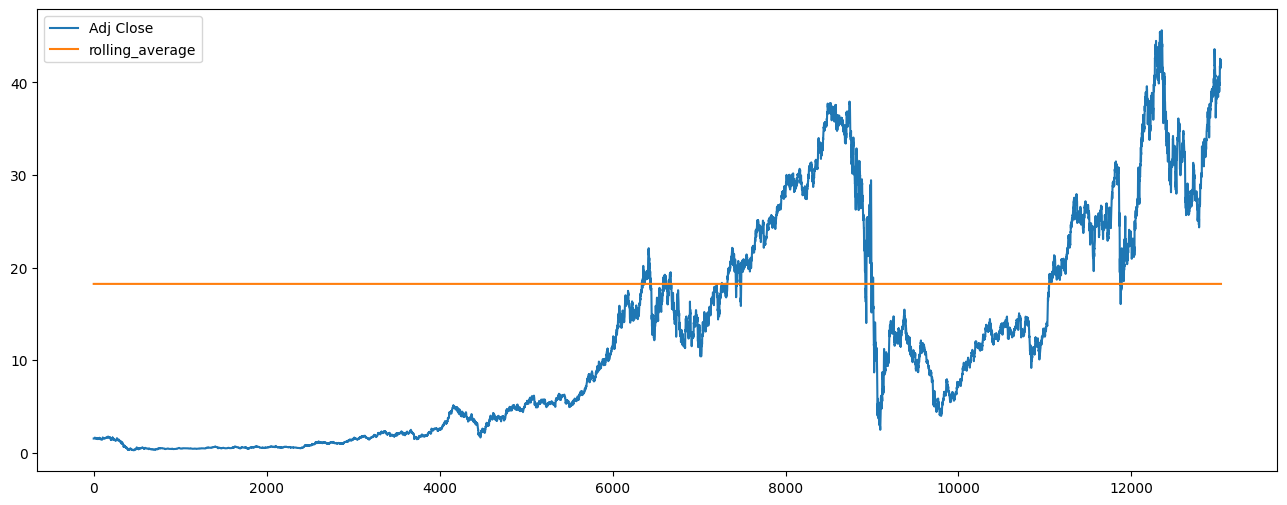

In [19]:
# Reference

import datetime
from pyspark.sql import functions as F
from pyspark.sql.window import Window


days = lambda i: i * 86400
#create window by casting timestamp to long (number of seconds)
w = (Window.orderBy(F.col("Date").cast('long')).rangeBetween(-days(7), 0))

df_mv_avg = df_pyspark.withColumn('rolling_average', F.avg("Close").over(w))
df_mv_avg.show(20, False)

pandas_df = df_mv_avg.toPandas()


pandas_df[['Adj Close', 'rolling_average']].plot(figsize=(16, 6))

In [20]:
# Let’s start by counting the number of rows in the pySaprk DataFrame :

(df_pyspark.count(), len(df_pyspark.columns))

(13037, 7)

In [21]:
# Basic statistics using pySpark

df_pyspark.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|         Adj Close|             Close|              High|               Low|              Open|             Volume|
+-------+------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|             13037|             13037|             13037|             13037|             13037|              13037|
|   mean| 12.39055596115427| 18.24658385613876| 18.45791770492566|18.038624898471323|17.618282721654726|3.871028226585871E7|
| stddev|11.586498122570738|14.652486541522679|14.788750556852653|14.510092483613258|15.336289080560064|7.741379038417119E7|
|    min|0.2762014865875244|          0.828125|             0.875|          0.828125|               0.0|                  0|
|    max| 45.63787078857422|54.900001525878906| 55.08000183105469| 54.81999969482422|55.040000915527344|         1226791300|


### Let’s explore the data by calculating some basic statistics such as the average closing price per year and per month for each stock dataset

In [22]:
from pyspark.sql.functions import year, month, avg
import pyspark.sql.functions as F

# Calculate average closing price per year and per month
avg_year = df_pyspark.select(year("Date").alias("Year"), "Close") \
                          .groupby("Year").avg("Close").sort("Year")
print(avg_year.head())

avg_month = df_pyspark.select(month("Date").alias("Month"), "Close") \
                            .groupby("Month").avg("Close").sort("Month")

print(avg_month.head())

Row(Year=1973, avg(Close)=4.70377006880734)
Row(Month=1, avg(Close)=17.934478819257595)


In [23]:
# On what day stock price was the highest?

df_pyspark.sort("High", ascending=False).collect()[0]['Date']

datetime.date(2006, 11, 20)

In [24]:
# What is the average Closing price?

df_pyspark.select(F.avg("Close")).show()

+-----------------+
|       avg(Close)|
+-----------------+
|18.24658385613876|
+-----------------+



In [25]:
# What is the maximum and minimum volume of stock traded?

df_pyspark.select(F.min("Volume"), F.max("Volume")).show()

+-----------+-----------+
|min(Volume)|max(Volume)|
+-----------+-----------+
|          0| 1226791300|
+-----------+-----------+



In [26]:
# For how many days the closing value was less than 6.0?

len(df_pyspark.filter((df_pyspark['Close']<6.0) & (df_pyspark['Close']>4.0)).collect())

1036

In [27]:
# What could be the maximum high value for each year?

df_pyspark.groupby(F.year("Date")).max("High").sort("max(High)", ascending=False).show(5)

+----------+------------------+
|year(Date)|         max(High)|
+----------+------------------+
|      2006| 55.08000183105469|
|      2007|54.209999084472656|
|      2022| 50.11000061035156|
|      2021|48.689998626708984|
|      2004|47.470001220703125|
+----------+------------------+
only showing top 5 rows



In [28]:
from pyspark.sql.types import FloatType
df_hv_ratio=df_pyspark.withColumn("HV Ratio", df_pyspark['High']/df_pyspark['Volume'])
df_hv_ratio.show(5)

+----------+------------------+--------+--------+--------+--------+------+--------------------+
|      Date|         Adj Close|   Close|    High|     Low|    Open|Volume|            HV Ratio|
+----------+------------------+--------+--------+--------+--------+------+--------------------+
|1973-02-21| 1.542557954788208|   4.625|   4.625|   4.625|   4.625| 99200|4.662298387096774...|
|1973-02-22|1.5477708578109741|4.640625|4.640625|4.640625|4.640625| 47200|9.831832627118644E-5|
|1973-02-23| 1.542557954788208|   4.625|   4.625|   4.625|   4.625|133600|3.461826347305389...|
|1973-02-26| 1.542557954788208|   4.625|   4.625|   4.625|   4.625| 24000|1.927083333333333...|
|1973-02-27| 1.542557954788208|   4.625|   4.625|   4.625|   4.625| 41600|1.111778846153846...|
+----------+------------------+--------+--------+--------+--------+------+--------------------+
only showing top 5 rows



In [29]:
df_pyspark.sort(F.desc("Date")).show(5)

+----------+------------------+------------------+------------------+------------------+------------------+--------+
|      Date|         Adj Close|             Close|              High|               Low|              Open|  Volume|
+----------+------------------+------------------+------------------+------------------+------------------+--------+
|2024-10-30| 42.07594680786133|42.310001373291016|42.900001525878906| 41.63999938964844|41.709999084472656|38100500|
|2024-10-29| 42.29472732543945|42.529998779296875|42.810001373291016|42.470001220703125| 42.59000015258789|22313500|
|2024-10-28| 42.38422775268555|42.619998931884766|             42.75|  42.0099983215332| 42.06999969482422|24527600|
|2024-10-25|41.658267974853516| 41.88999938964844| 42.97999954223633|41.790000915527344| 42.91999816894531|27466900|
|2024-10-24|42.414066314697266|42.650001525878906| 42.65999984741211|41.970001220703125| 42.31999969482422|28392000|
+----------+------------------+------------------+--------------

In [30]:
last_row = df_pyspark.orderBy(F.desc("Date")).limit(1).collect()[0]
last_row

Row(Date=datetime.date(2024, 10, 30), Adj Close=42.07594680786133, Close=42.310001373291016, High=42.900001525878906, Low=41.63999938964844, Open=41.709999084472656, Volume=38100500)

Statistical Analysis with Spark SQL Additionally, we can leverage Spark SQL to perform complex analytical queries. Let’s calculate the previous day’s volume for each stock using SQL queries

In [31]:
# Create temporary views for SQL queries
df_pyspark.createOrReplaceTempView("BAC_TABLE")

# Calculate previous day's volume using SQL
previous_day = spark.sql("""
    SELECT *, LAG(Volume, 1, 0) OVER (PARTITION BY MONTH(Date) ORDER BY Date) as Previous_Day_Volume
    FROM BAC_TABLE
""")

previous_day.show(5)

+----------+------------------+--------+--------+--------+----+------+-------------------+
|      Date|         Adj Close|   Close|    High|     Low|Open|Volume|Previous_Day_Volume|
+----------+------------------+--------+--------+--------+----+------+-------------------+
|1974-01-02|1.6311508417129517|4.890625|4.953125|4.890625| 0.0|121600|                  0|
|1974-01-03|1.6572073698043823| 4.96875| 5.03125| 4.96875| 0.0| 95200|             121600|
|1974-01-04|1.6259409189224243|   4.875|  4.9375|   4.875| 0.0|156000|              95200|
|1974-01-07|1.5998833179473877|4.796875|4.859375|4.796875| 0.0| 71200|             156000|
|1974-01-08|1.5790385007858276|4.734375|4.796875|4.734375| 0.0| 87200|              71200|
+----------+------------------+--------+--------+--------+----+------+-------------------+
only showing top 5 rows



In [32]:
#Perform descriptive analytics
df_pyspark.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Adj Close,13037,12.39055596115427,11.586498122570738,0.2762014865875244,45.63787078857422
Close,13037,18.24658385613876,14.652486541522679,0.828125,54.900001525878906
High,13037,18.45791770492566,14.788750556852653,0.875,55.08000183105469
Low,13037,18.038624898471323,14.510092483613258,0.828125,54.81999969482422
Open,13037,17.618282721654726,15.336289080560064,0.0,55.040000915527344
Volume,13037,3.871028226585871E7,7.741379038417119E7,0,1226791300


**Data Preprocessing**

### Dataype conversion to make it simpler

In [33]:
from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType
from pyspark.sql import functions as F

# Specify the columns and their desired data types in a dictionary
columns_to_convert = {
    "Adj Close": FloatType(),
    "Close": FloatType(),
    "High": FloatType(),
    "Low": FloatType(),
    "Open": FloatType(),
    "Volume": IntegerType(),
    # Add more columns and data types as needed
}

# Iterate through the dictionary and apply the conversions
for column_name, data_type in columns_to_convert.items():
    df_pyspark = df_pyspark.withColumn(column_name, col(column_name).cast(data_type))

df_pyspark = df_pyspark.withColumn("Date", F.to_date("Date", "yyyy-MM-dd"))

df_pyspark.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Open: float (nullable = true)
 |-- Volume: integer (nullable = true)



### Identifying Missing Values

In [34]:
from pyspark.sql.functions import col, count, when

# Assuming 'pyspark_df' is your DataFrame
null_counts = df_pyspark.select([count(when(col(c).isNull(), c)).alias(c) for c in df_pyspark.columns])
null_counts.show() # show no null values

+----+---------+-----+----+---+----+------+
|Date|Adj Close|Close|High|Low|Open|Volume|
+----+---------+-----+----+---+----+------+
|   0|        0|    0|   0|  0|   0|     0|
+----+---------+-----+----+---+----+------+



### Traint/Test Data Splitting in ratio 70/30 %

In [35]:
# Split the data into a training set and a test set
(trainingData, testData) = df_pyspark.randomSplit([0.7, 0.3], seed=42)

### VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like logistic regression and decision trees.

In [36]:
# Define the characteristics and the target variable

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['Adj Close','High', 'Low', 'Open', 'Volume'], outputCol='features')

trainingData = assembler.transform(trainingData)
testData = assembler.transform(testData)

trainingData = trainingData.select("features", "Close")
testData = testData.select("features", "Close")

display = trainingData.select(['features', 'Close'])
display.show(3)

+--------------------+--------+
|            features|   Close|
+--------------------+--------+
|[1.54255795478820...|   4.625|
|[1.54777085781097...|4.640625|
|[1.54255795478820...|   4.625|
+--------------------+--------+
only showing top 3 rows



### Util function for Metrices Evaluation

In [37]:
from typing import Any
from pyspark.ml.evaluation import RegressionEvaluator

def evaluation_metrices(predictions = Any):
  # mean square error
  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="mse")
  mse = evaluator.evaluate(predictions)

  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
  rmse = evaluator.evaluate(predictions)

  # coefficient of determination
  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")
  r2 = evaluator.evaluate(predictions)

  print('MSE:', mse)
  print('RMSE:', rmse)
  print('R2:', r2)
  r2

### Util function for Visualtion / plotting the actual vs predicted values

In [58]:
# Visualization
# Plot the actual vs predicted values for adjusted closing prices

def predicted_vs_actual_visualization(model : str, predictions : Any):
  title = 'Actual vs Predicted Closing Prices using ' + '<' + model + '>'
  preds = predictions.select("Close", "prediction").toPandas()
  plt.figure(figsize=(12, 6))
  plt.plot(preds["Close"], label='Actual', color='blue')
  plt.plot(preds["prediction"], label='Predicted', color='red', alpha=0.6)
  plt.title(title)
  plt.xlabel('Days')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()

### LinearRegression
#### This model is a type of supervised machine learning algorithm that computes the linear relationship between the dependent variable and one or more independent features by fitting a linear equation to observed data

In [41]:
from pyspark.ml.regression import LinearRegression

# Create the model using PySpark's linear regression algorithm
lr = LinearRegression(labelCol="Close", featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [42]:
# Train the model using the training set

lrModel = lr.fit(trainingData)

lrModel

LinearRegressionModel: uid=LinearRegression_a893cd5a38db, numFeatures=5

In [43]:
# Perform the prediction using the test suite

predictions = lrModel.transform(testData)

predictions.select("prediction","Close","features").show()

+------------------+--------+--------------------+
|        prediction|   Close|            features|
+------------------+--------+--------------------+
| 5.198797568415792|   4.625|[1.54255795478820...|
|  5.22900740210738| 4.65625|[1.55298185348510...|
|  5.30453195889201|4.734375|[1.57903850078582...|
| 5.440476165115441|   4.875|[1.62594091892242...|
| 5.455581064016859|4.890625|[1.63115084171295...|
| 5.470685980862653| 4.90625|[1.63636279106140...|
| 5.485790901930653|4.921875|[1.64157521724700...|
| 5.319636866237841|    4.75|[1.58424937725067...|
| 5.183692655792204|4.609375|[1.53734648227691...|
|  5.16858775266858| 4.59375|[1.53213608264923...|
|  5.16858775266858| 4.59375|[1.53213608264923...|
|5.2592172167990405|  4.6875|[1.56340360641479...|
|  5.22900740210738| 4.65625|[1.55298185348510...|
| 5.198797568415792|   4.625|[1.54255795478820...|
| 5.183692655792204|4.609375|[1.53734648227691...|
|5.2894270378240105| 4.71875|[1.57382607460021...|
| 5.319636866237841|    4.75|[1

In [44]:
evaluation_metrices(predictions =  predictions)

MSE: 0.2385408327564566
RMSE: 0.4884064216986265
R2: 0.9989095462292027


R squared at 0.99 indicates that in our model, approximate 99% of the variability in “Adj Close” can be explained using the model, which is pretty good.

RMSE measures the differences between predicted values by the model and the actual values. However, RMSE alone is meaningless until we compare with the actual “Close Value” value, such as mean, min and max. After such comparison, our RMSE looks good.

In [45]:
trainingData.describe().show()

+-------+------------------+
|summary|             Close|
+-------+------------------+
|  count|              9223|
|   mean| 18.07496027223694|
| stddev|14.591649098193153|
|    min|          0.828125|
|    max|              54.9|
+-------+------------------+



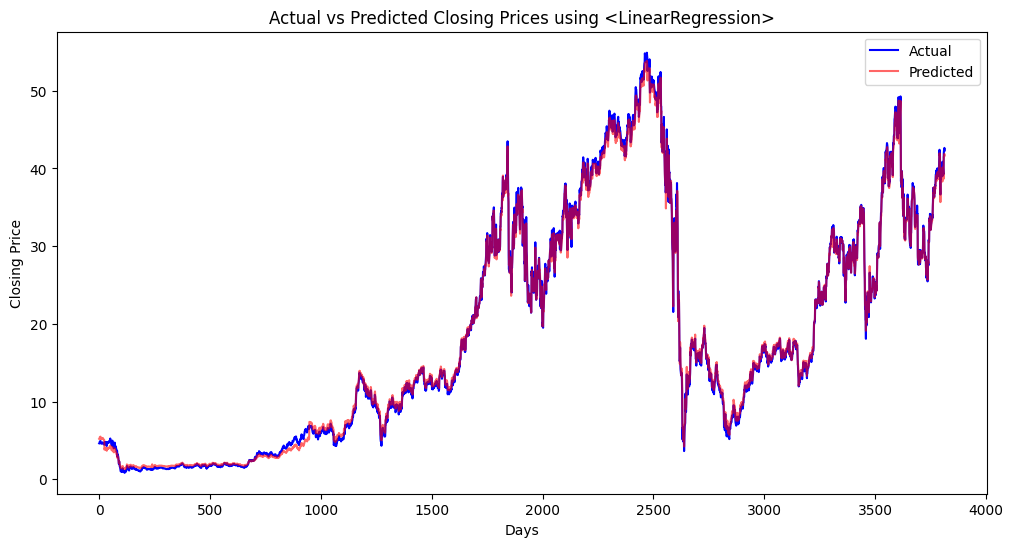

In [46]:
predicted_vs_actual_visualization(model = 'LinearRegression', predictions = predictions)

### GBT Regressor
#### This model starts by fitting a simple model to the data, such as a decision tree with one or two levels.
The residuals from this model are then used to train a second model, which is added to the ensemble. This process is repeated many times, with each new model trained on the residuals of the previous models. The final predictor is the sum of all the models in the ensemble.


In [47]:
from pyspark.ml.regression import GBTRegressor

# Create the model using PySpark's linear regression algorithm
gbtr =  GBTRegressor(labelCol="Close", featuresCol="features", maxIter=50)

In [48]:
# Train the model using the training set

gbtrModel = gbtr.fit(trainingData)

gbtrModel

GBTRegressionModel: uid=GBTRegressor_f9cd77bfeb02, numTrees=50, numFeatures=5

In [49]:
# Perform the prediction using the test suite

predictions = gbtrModel.transform(testData)

predictions.select("prediction","Close","features").show()

+-----------------+--------+--------------------+
|       prediction|   Close|            features|
+-----------------+--------+--------------------+
|4.735034631439777|   4.625|[1.54255795478820...|
|4.735034631439777| 4.65625|[1.55298185348510...|
|4.735034631439777|4.734375|[1.57903850078582...|
|4.735034631439777|   4.875|[1.62594091892242...|
|4.735034631439777|4.890625|[1.63115084171295...|
|4.735034631439777| 4.90625|[1.63636279106140...|
|4.938959329691405|4.921875|[1.64157521724700...|
|4.735034631439777|    4.75|[1.58424937725067...|
|4.735034631439777|4.609375|[1.53734648227691...|
|4.735034631439777| 4.59375|[1.53213608264923...|
|4.735034631439777| 4.59375|[1.53213608264923...|
|4.735034631439777|  4.6875|[1.56340360641479...|
|4.735034631439777| 4.65625|[1.55298185348510...|
|4.735034631439777|   4.625|[1.54255795478820...|
|4.735034631439777|4.609375|[1.53734648227691...|
|4.735034631439777| 4.71875|[1.57382607460021...|
|4.735034631439777|    4.75|[1.58424937725067...|


In [50]:
evaluation_metrices(predictions =  predictions)

MSE: 0.2719409818005985
RMSE: 0.5214796082308478
R2: 0.9987568624389705


R squared at 0.99 indicates that in our model, approximate 99% of the variability in “Adj Close” can be explained using the model, which is pretty good.

In [51]:
gbtrModel.featureImportances

SparseVector(5, {0: 0.0047, 1: 0.1058, 2: 0.8878, 3: 0.0003, 4: 0.0013})

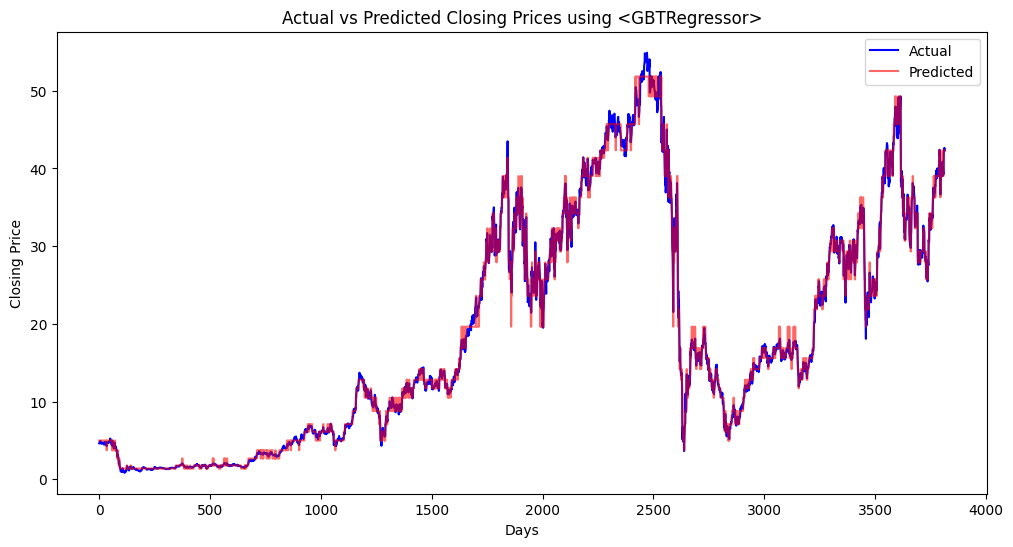

In [59]:
predicted_vs_actual_visualization(model = 'GBTRegressor', predictions =  predictions)

### DecisionTreeRegressor
#### This model observes features of an object and trains a model in the structure of a tree to predict data in the future to produce meaningful continuous output. Continuous output means that the output/result is not discrete, i.e., it is not represented just by a discrete, known set of numbers or values.

In [53]:
from pyspark.ml.regression import DecisionTreeRegressor

dtr = DecisionTreeRegressor(labelCol = 'Close', featuresCol ='features')

dtrModel = dtr.fit(trainingData)

dtrModel

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_52ed6e12d3ad, depth=5, numNodes=63, numFeatures=5

In [54]:
# Perform the prediction using the test suite
predictions = dtrModel.transform(testData)

predictions.select("prediction","Close","features").show()

+-----------------+--------+--------------------+
|       prediction|   Close|            features|
+-----------------+--------+--------------------+
|4.987087264069153|   4.625|[1.54255795478820...|
|4.987087264069153| 4.65625|[1.55298185348510...|
|4.987087264069153|4.734375|[1.57903850078582...|
|4.987087264069153|   4.875|[1.62594091892242...|
|4.987087264069153|4.890625|[1.63115084171295...|
|4.987087264069153| 4.90625|[1.63636279106140...|
|4.987087264069153|4.921875|[1.64157521724700...|
|4.987087264069153|    4.75|[1.58424937725067...|
|4.987087264069153|4.609375|[1.53734648227691...|
|4.987087264069153| 4.59375|[1.53213608264923...|
|4.987087264069153| 4.59375|[1.53213608264923...|
|4.987087264069153|  4.6875|[1.56340360641479...|
|4.987087264069153| 4.65625|[1.55298185348510...|
|4.987087264069153|   4.625|[1.54255795478820...|
|4.987087264069153|4.609375|[1.53734648227691...|
|4.987087264069153| 4.71875|[1.57382607460021...|
|4.987087264069153|    4.75|[1.58424937725067...|


In [55]:
evaluation_metrices(predictions =  predictions)

MSE: 0.5127160184017264
RMSE: 0.7160419110650762
R2: 0.9976561953391637


In [56]:
dtrModel.featureImportances

SparseVector(5, {0: 0.0008, 1: 0.1041, 2: 0.8949, 4: 0.0002})

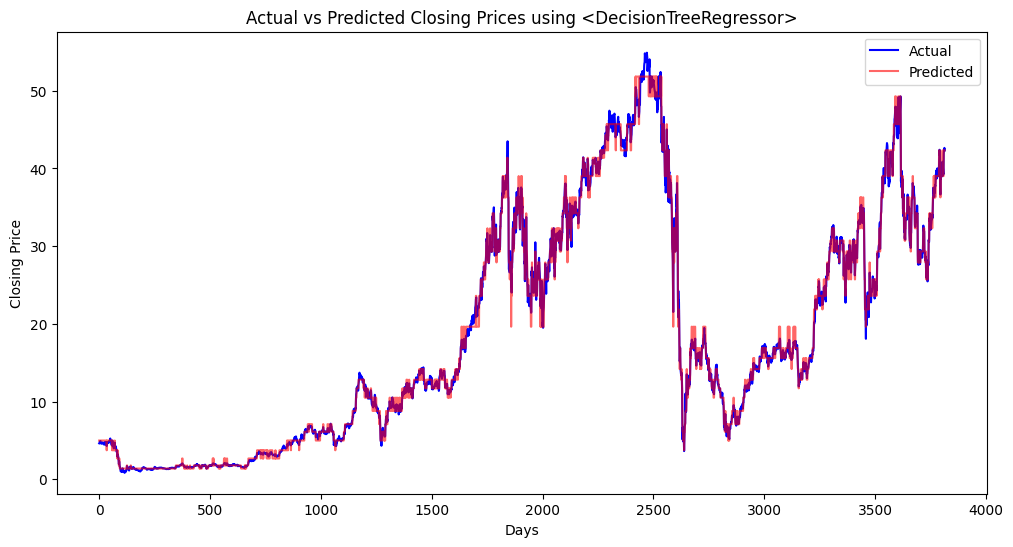

In [60]:
predicted_vs_actual_visualization(model = 'DecisionTreeRegressor', predictions =  predictions)

# **LSTM with the Attention Mechanism in TensorFlow**

Long Short-Term Memory Networks or LSTM in deep learning, is a sequential neural network that allows information to persist. It is a special type of Recurrent Neural Network which is capable of handling the vanishing gradient problem faced by RNN. LSTM was designed by Hochreiter and Schmidhuber that resolves the problem caused by traditional rnns and machine learning algorithms. LSTM Model can be implemented in Python using the Keras library.


Normalization:

Normalization is a technique used to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. Applying Min-Max Scaling: This scales the dataset so that all the input features lie between 0 and 1.

In [61]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

#Converting DataFrame to Pandas DataFrame
pandas_df = df_pyspark.toPandas()

# Now you can use .values and .reshape()
scaler = MinMaxScaler(feature_range=(0,1))
pandas_df_scaled = scaler.fit_transform(pandas_df["Close"].values.reshape(-1,1))
pandas_df_scaled

array([[0.07021903],
       [0.070508  ],
       [0.07021903],
       ...,
       [0.77289486],
       [0.7712304 ],
       [0.7671618 ]], dtype=float32)

Creating Sequences

LSTM models require input to be in a sequence format. We transform the data into sequences for the model to learn from.

Defining Sequence Length: Choose a sequence length (like 60 days). This means, for every sample, the model will look at the last 60 days of data to make a prediction.

In [62]:
X = []
y = []

for i in range(60, len(pandas_df_scaled)):
    X.append(pandas_df_scaled[i-60:i, 0])
    y.append(pandas_df_scaled[i, 0])

In [63]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Reshaping Data for LSTM

Finally, we need to reshape our data into a 3D format [samples, time steps, features] required by LSTM layers.

In [64]:
import numpy as np

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Building the LSTM with Attention Model

In this section, we’ll dive into the construction of our LSTM model with an added attention mechanism, tailored for predicting Bank of America stock patterns. This requires TensorFlow and Keras, which should already be set up in your Colab environment.

Creating LSTM Layers

Our LSTM model will consist of several layers, including LSTM layers for processing the time-series data. The basic structure is as follows:

In [65]:
import tensorflow as tf
print("TensorFlow Version: ", tf.__version__)

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))

TensorFlow Version:  2.17.1


Integrating the Attention Mechanism

The attention mechanism can be added to enhance the model’s ability to focus on relevant time steps:

In [66]:
# Access the output of the second LSTM layer using model.layers
x = model.layers[-1].output # Get the output of the last added layer

# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')

# Permute and reshape for compatibility
x = Permute((2, 1))(x)
x = Reshape((-1, X_train.shape[1]))(x)

attention_result = attention([x, x])
multiply_layer = Multiply()([x, attention_result])
# Return to original shape
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

# Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=25,

This custom layer computes a weighted sum of the input sequence, allowing the model to pay more attention to certain time steps

Optimizing the Model

To enhance the model’s performance and reduce the risk of overfitting, we include Dropout and Batch Normalization.

In [67]:
from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

Dropout helps in preventing overfitting by randomly setting a fraction of the input units to 0 at each update during training, and Batch Normalization stabilizes the learning process.

Model Compilation

Finally, we compile the model with an optimizer and loss function suited for our regression task.

In [68]:
# adam optimizer is generally a good choice for recurrent neural networks, and mean squared error works well as a loss function for regression tasks like ours.
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [69]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ permute_1 (Permute)                  │ (None, 50, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           3,001 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1)                   │               4 │
│ (BatchNormalization)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,605 (131.27 KB)

 Trainable params: 33,603 (131.26 KB)

 Non-trainable params: 2 (8.00 B)

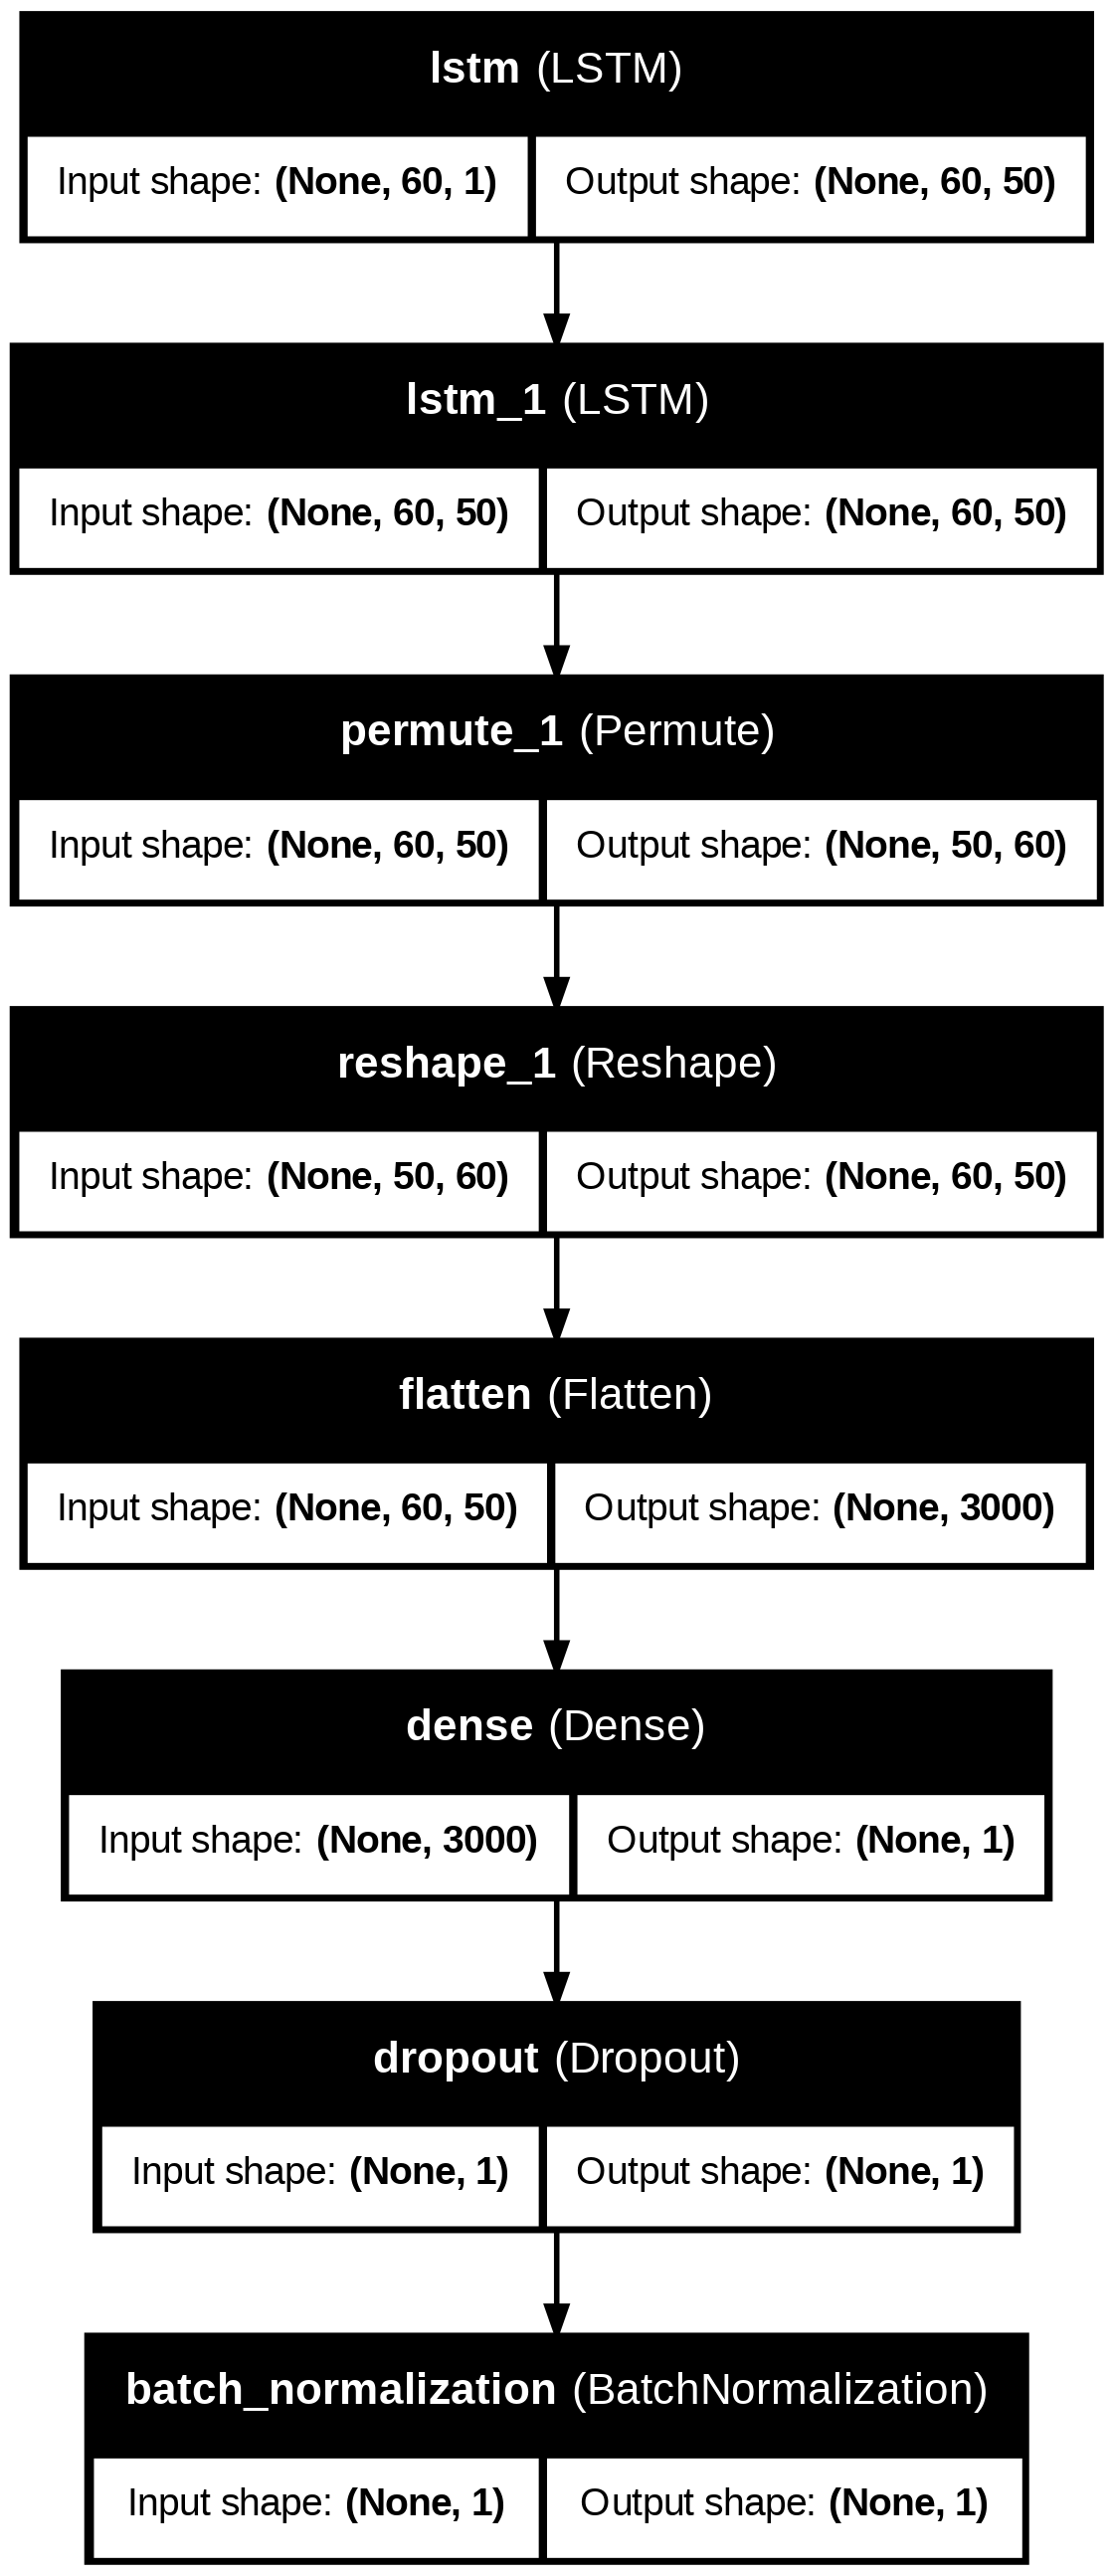

In [70]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

Training the Model

Now that our LSTM model with attention is built, it’s time to train it using our prepared training set. This process involves feeding the training data to the model and letting it learn to make predictions.

Overfitting and How to Avoid It

Overfitting and How to Avoid It Overfitting occurs when a model learns patterns specific to the training data, which do not generalize to new data. Here are ways to avoid overfitting:

Validation Set: Using a validation set (as we did in the training code) helps in monitoring the model’s performance on unseen data. Early Stopping: This technique stops training when the model’s performance on the validation set starts to degrade. Implementing early stopping in Keras is straightforward:

In [71]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [72]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Callback to save the model periodically
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for TensorBoard
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
model.fit(X_train, y_train, epochs=25, batch_size=25, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - loss: 0.1426 - mean_absolute_error: 0.2615 - val_loss: 0.0887 - val_mean_absolute_error: 0.1909 - learning_rate: 0.0010
Epoch 2/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 25s 74ms/step - loss: 0.0181 - mean_absolute_error: 0.0842 - val_loss: 0.0128 - val_mean_absolute_error: 0.0844 - learning_rate: 0.0010
Epoch 3/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - loss: 0.0148 - mean_absolute_error: 0.0749 - val_loss: 0.0042 - val_mean_absolute_error: 0.0430 - learning_rate: 0.0010
Epoch 4/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - loss: 0.0166 - mean_absolute_error: 0.0812 - val_loss: 0.0049 - val_mean_absolute_error: 0.0500 - learning_rate: 0.0010
Epoch 5/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - loss: 0.0168 - mean_absolute_error: 0.0785 - val_loss: 0.0031 - val_mean_absolute_error: 0.0397 - learning_rate: 0.0010
Epoch 6/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 38s 66ms/step - loss: 0.0163 - mean_absolute_error: 0.0793 - val_loss: 0.0039 - 

Evaluating Model Performance

After training the model, the next step is to evaluate its performance using the test set. This will give us an understanding of how well our model can generalize to new, unseen data.

Evaluating with the Test Set To evaluate the model, we first need to prepare our test data (X_test) in the same way we did for the training data. Then, we can use the model's evaluate function:

In [73]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Evaluate the model on the test set to see its performance
# Returns the loss and accuracy on the test data
loss, mean_absolute_error = model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print(f'Loss: {loss}, mean_absolute_error: {mean_absolute_error}')

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0021 - mean_absolute_error: 0.0363
Loss: 0.004395841620862484, mean_absolute_error: 0.057223234325647354


Performance Metrics In addition to the loss, other metrics can provide more insights into the model’s performance. For regression tasks like ours, common metrics include:

Mean Absolute Error (MAE): This measures the average magnitude of the errors in a set of predictions, without considering their direction. Root Mean Square Error (RMSE): This is the square root of the average of squared differences between prediction and actual observation.

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Print the predicted value
print(f'Predicted value: {y_pred[0][0]}')

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Predicted value: 0.2635488510131836
Mean Absolute Error:  0.057223238
Root Mean Square Error:  0.066301145


### Predict the next 4 days iteratively

In [75]:
predicted_prices = []
inverse_predicted_prices = []
current_batch = pandas_df_scaled[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Calculating MAE and RMSE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    print("Mean Absolute Error: ", mae)
    print("Root Mean Square Error: ", rmse)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])
    print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Mean Absolute Error:  0.057223238
Root Mean Square Error:  0.066301145
Predicted Stock Prices for the next 4 days:  [36.832138]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Mean Absolute Error:  0.057223238
Root Mean Square Error:  0.066301145
Predicted Stock Prices for the next 4 days:  [36.832138, 36.321438]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mean Absolute Error:  0.057223238
Root Mean Square Error:  0.066301145
Predicted Stock Prices for the next 4 days:  [36.832138, 36.321438, 35.547558]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Mean Absolute Error:  0.057223238
Root Mean Square Error:  0.066301145
Predicted Stock Prices for the next 4 days:  [36.832138, 36.321438, 35.547558, 34.60598]
Predicted Stock Prices for the next 4 days:  [36.832138, 36.321438, 35.547558, 34.60598]
